In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/21 - Pytorch/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/21 - Pytorch


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Basic 

In [ ]:
df = pd.read_csv('./data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


<Figure size 1080x360 with 0 Axes>

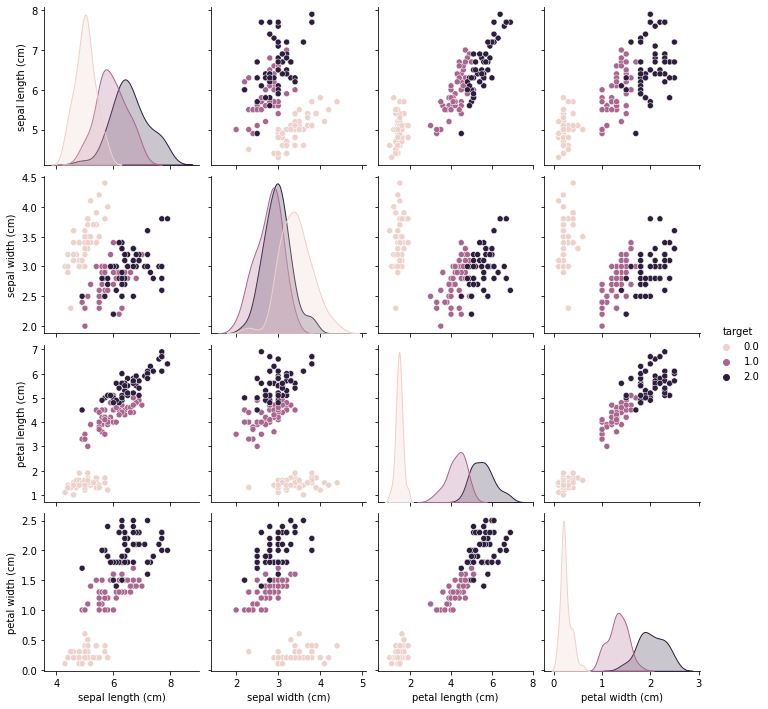

In [ ]:
plt.figure(figsize=(15,5))
sns.pairplot(df, hue='target');

In [ ]:
X = df.drop(columns='target').values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y is belong to label/category
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
# create batch size, 2 x 60
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
testloader = DataLoader(X_test, batch_size=60, shuffle=False)

for i,j  in enumerate(trainloader):
    print(i, j.shape)

0 torch.Size([60, 4])
1 torch.Size([60, 4])


In [ ]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        # add activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
# Defining Model
torch.manual_seed(4)
model = Model(4, 8, 9, 3)

# BCELoss() for Binary Cross Entropy
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 201
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%50 == 1:
        print("epoch:", i, "loss", loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 1 loss 1.0956823825836182
epoch: 51 loss 0.22807984054088593
epoch: 101 loss 0.060887958854436874
epoch: 151 loss 0.051819317042827606
epoch: 201 loss 0.04808415472507477


 0.047


Text(0.5, 0, 'epoch')

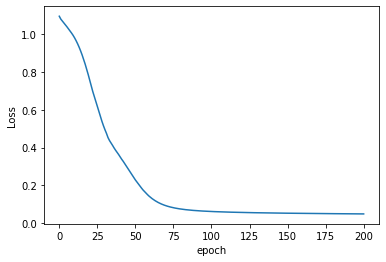

In [ ]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    pred = model.forward(X_test)
    # the loss of testing shold resemble loss of training
    loss = criterion(pred, y_test)
print(f'{loss: .3f}')

# loss during training
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [ ]:
# predictions
correct = 0
with torch.no_grad():
    for i, x_inp in enumerate(X_test):
        pred = model.forward(x_inp)
        # pred.argmax() to get the output with max probabilities
        if pred.argmax().item() == y_test[i]:
            correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')


30 out of 30 = 100.00% correct


In [ ]:
# save and load model
torch.save(model.state_dict(), './model/IrisModel.pt')
new_model = Model()
new_model.load_state_dict(torch.load('./model/IrisModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [ ]:
mystery_iris = torch.tensor([5.6, 3.7, 2.2, 0.5])
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

# no backpropagation during testing, so we can turn it off
with torch.no_grad():
    pred = model.forward(mystery_iris)
    print(pred)
    print()
    print(labels[pred.argmax()])

tensor([ 16.3881,  10.7361, -24.7470])

Iris setosa


# ANN - Classification

## Pre-Processing

The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    return d

In [ ]:
df = pd.read_csv('./data/NYCTaxiFares.csv')
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:-4]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12, 'am', 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.drop(columns=['pickup_datetime', 'EDTdate'], inplace=True)
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,Hour,AMorPM,Weekday
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4,am,Mon
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,11,am,Sat
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,7,am,Sat
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,17,pm,Sun
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,22,pm,Fri


In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    df[cat] = df[cat].cat.codes
    
y = torch.tensor(df['fare_class'].values).flatten()
cats = df[cat_cols].values
cats = torch.tensor(cats, dtype=torch.int64)
conts = df[cont_cols].values
conts = torch.tensor(conts, dtype=torch.float)

## Embedding

Similar to one hot encoding.

The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [ ]:
# 24 hours, 2 AM/PM, 7 days
cat_szs = [df[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
class TabularModel(nn.Module):
    '''
    emb_szs: list of tuples. Each categorical variable size is paired with an embedding size
    n_cont: int. Number of continuous variables
    out_sz: int. Output size
    layers: list of ints. Layer sizes
    p: float. Dropout probability for each layer
    '''
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        # embedded layer
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        # dropout layer
        self.emb_drop = nn.Dropout(p)
        # normalization layer
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        # number of categorical features
        n_emb = sum((nf for ni,nf in emb_szs))
        # total number of features
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        # one last layer. output
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        # filter categorical features
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [ ]:
torch.manual_seed(33)
# 2 output classes, 2 layers with 200 & 100 neurons.
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 60000
test_size = 12000

# test and train size
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

print(len(cat_train))
print(len(cat_test))

48000
12000


## Model Training

In [ ]:
import time
start_time = time.time()

epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%50 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.82983243
epoch:  51  loss: 0.33750707
epoch: 100  loss: 0.30243054

Duration: 100 seconds


## Evaluation

CE Loss: 0.29233375


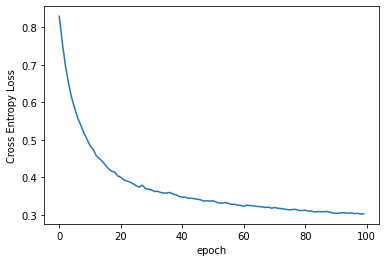

In [ ]:
with torch.no_grad():
    pred = model.forward(cat_test, con_test)
    loss = criterion(pred, y_test)
print(f'CE Loss: {loss:.8f}')

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'Pred: {pred[i].argmax()} Actual: {y_test[i]}')
    if pred[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
Pred: 0 Actual: 0
Pred: 1 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 1
Pred: 0 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 1
Pred: 1 Actual: 1
Pred: 0 Actual: 0
Pred: 0 Actual: 0
Pred: 1 Actual: 0

45 out of 50 = 90.00% correct


# ANN - Regression

## Pre-Processing (Refer to 2.1)

In [ ]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,Hour,AMorPM,Weekday
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4,0,1
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,11,0,2
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,7,0,2
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,17,1,3
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,22,1,0


In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount'] 

y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
cats = df[cat_cols].values
cats = torch.tensor(cats, dtype=torch.int64)
conts = df[cont_cols].values
conts = torch.tensor(conts, dtype=torch.float)

## Embedding

In [ ]:
cat_szs = [df[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

print(len(cat_train))
print(len(cat_test))

48000
12000


## Model Traning

In [ ]:
import time
start_time = time.time()

epochs = 2
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56901932
epoch:   2  loss: 12.46980190

Duration: 2 seconds


## Evaluation

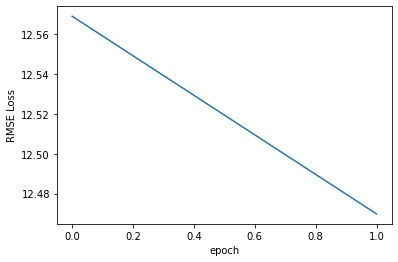

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    pred = model.forward(cat_test, con_test)
    loss = torch.sqrt(criterion(pred, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 12.31702042


In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(pred[i].item() - y_test[i].item())
    print(f'{i+1:2}. {pred[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  -0.4778   2.9000   3.3778
 2.   1.2907   5.7000   4.4093
 3.   1.3348   7.7000   6.3652
 4.   0.3515  12.5000  12.1485
 5.  -0.1202   4.1000   4.2202
 6.  -0.1746   5.3000   5.4746
 7.  -0.3527   3.7000   4.0527
 8.  -0.6736  14.5000  15.1736
 9.   0.2049   5.7000   5.4951
10.  -0.7851  10.1000  10.8851
11.  -0.8420   4.5000   5.3420
12.  -2.0324   6.1000   8.1324
13.   1.1063   6.9000   5.7937
14.  -0.5545  14.1000  14.6545
15.   1.1115   4.5000   3.3885
16.   1.7524  34.1000  32.3476
17.  -2.0377  12.5000  14.5377
18.  -0.5742   4.1000   4.6742
19.  -0.2985   8.5000   8.7985
20.  -0.5087   5.3000   5.8087
21.  -0.8241  11.3000  12.1241
22.  -0.5746  10.5000  11.0746
23.   0.3627  15.3000  14.9373
24.  -0.3992  14.9000  15.2992
25.   2.4426  49.5700  47.1274
26.   0.5289   5.3000   4.7711
27.  -1.5167   3.7000   5.2167
28.  -1.5317   6.5000   8.0317
29.   0.2400  14.1000  13.8600
30.  -0.1470   4.9000   5.0470
31.   0.7139   3.7000   2.9861
32.   1.

In [ ]:
torch.save(model.state_dict(), './model/TaxiFareRegrModel.pt')

# ANN - MNIST

## Pre-Processing

In [ ]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# split 6000 dataset into 600 batches with 100 data each
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [ ]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

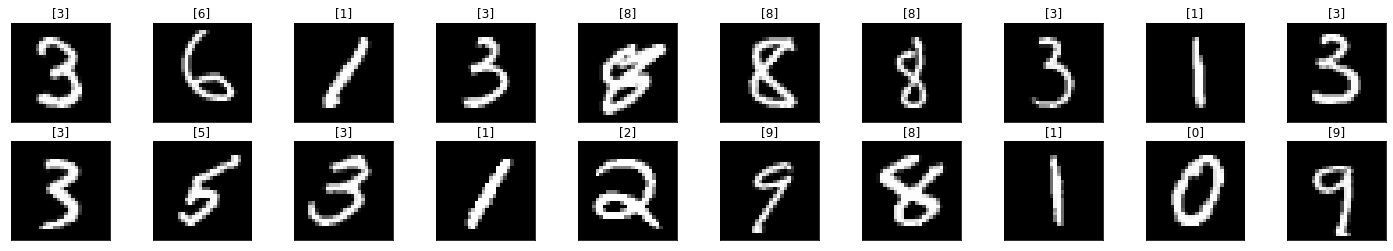

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

## Model Training

In [ ]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
# 10 epochs, each epochs with 600 batches, 100 dataset for each batch
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# epoch 1,2,3...10
for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    # batch 1,2,3...600, 100 dataset per batch
    for inputs, labels in training_loader:
        # convert shape (100, 1, 28, 28) into (100, 784)
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # find the actual predictions --> max probabilities of each row
        # axis 0 for columns, 1 for rows
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    # else statement is called after for loop if the loop IS NOT terminated
    else:
        # temporarily set no computation as gradient as no derivative required for validation
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    # loss per epoch, total loss/size of batches
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9466, acc 76.8367 
validation loss: 0.4431, validation acc 88.3100 
epoch : 2
training loss: 0.3855, acc 89.2483 
validation loss: 0.3422, validation acc 90.0600 
epoch : 3
training loss: 0.3254, acc 90.6267 
validation loss: 0.2930, validation acc 91.6700 
epoch : 4
training loss: 0.2929, acc 91.5767 
validation loss: 0.2741, validation acc 92.1500 
epoch : 5
training loss: 0.2693, acc 92.2350 
validation loss: 0.2521, validation acc 92.7700 
epoch : 6
training loss: 0.2495, acc 92.7850 
validation loss: 0.2351, validation acc 93.1800 
epoch : 7
training loss: 0.2319, acc 93.3183 
validation loss: 0.2197, validation acc 93.5500 
epoch : 8
training loss: 0.2157, acc 93.7850 
validation loss: 0.2057, validation acc 93.9000 
epoch : 9
training loss: 0.2024, acc 94.1250 
validation loss: 0.1951, validation acc 94.2500 
epoch : 10
training loss: 0.1887, acc 94.5100 
validation loss: 0.1811, validation acc 94.5200 


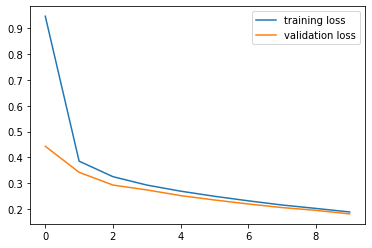

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

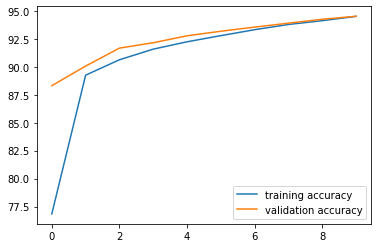

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

## Evaluation

In [ ]:
import PIL.ImageOps
import requests
from PIL import Image

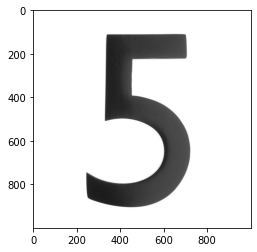

In [ ]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

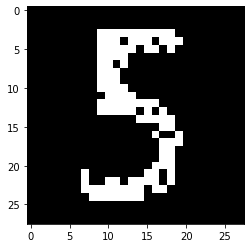

In [ ]:
# convert into same format using predifined transform object
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


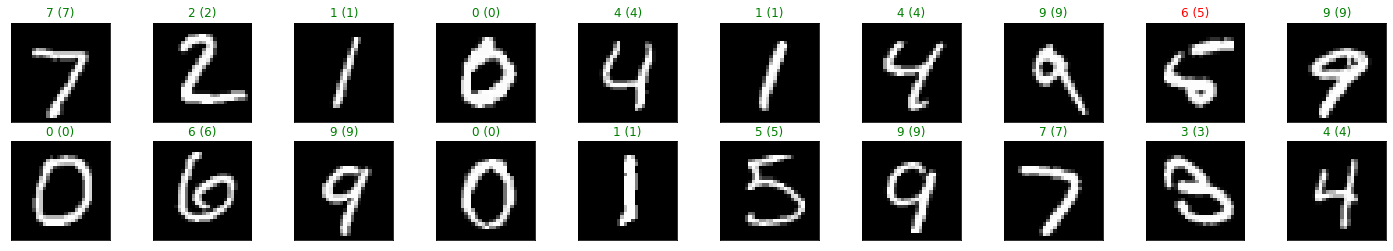

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))